# Background
In this project, we will attempt to generate images in the style of Monet. We will be using the generative adversarial networks architecture, consisting of a generator and discriminator.
At first we will explore a simple vanilla GAN network, followed by more complex variations.


## Data Description
The competition's dataset is composed of 4 directories, 2 of which containing tfrec files, and the other 2 jpg files.

In addition to the differing formats, the directories are also seperated to monet style images, and regular photos.

The number of images provided are:

monet_jpg - 300

monet_tfrec - 5

photo_jpg - 7038

photo_tfrec - 20

The images are 256x256 in size with 3 channels (RGB).

In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from tqdm import tqdm
from keras import layers, ops, initializers

from IPython.display import clear_output


INPUT_BASEPATH = "/kaggle/input/gan-getting-started"

# Loading the data

In [2]:
def get_filepaths(base_path, extension):
    paths = tf.io.gfile.glob(os.path.join(base_path,f'*.{extension}'))
    # for p in paths:
    #     yield p
    return paths

In [3]:
monet_tfrec_filepaths = get_filepaths(os.path.join(INPUT_BASEPATH,'monet_tfrec'), 'tfrec')
photo_tfrec_filepaths = get_filepaths(os.path.join(INPUT_BASEPATH,'photo_tfrec'), 'tfrec')
monet_jpg_filepaths = get_filepaths(os.path.join(INPUT_BASEPATH,'monet_jpg'), 'jpg')
photo_jpg_filepaths = get_filepaths(os.path.join(INPUT_BASEPATH,'photo_jpg'), 'jpg')

# EDA

In [4]:
print(f"Monet TFREC images count: {len(monet_tfrec_filepaths)}")
print(f"Photo TFREC images count: {len(photo_tfrec_filepaths)}")
print(f"Monet JPG images count: {len(monet_jpg_filepaths)}")
print(f"Photo JPG images count: {len(photo_jpg_filepaths)}")

Monet TFREC images count: 5
Photo TFREC images count: 20
Monet JPG images count: 300
Photo JPG images count: 7038


It seems like the TFREC datasets are quite small, so instead we will use the JPG datasets to train our GAN model

Also let's inspect some of the images

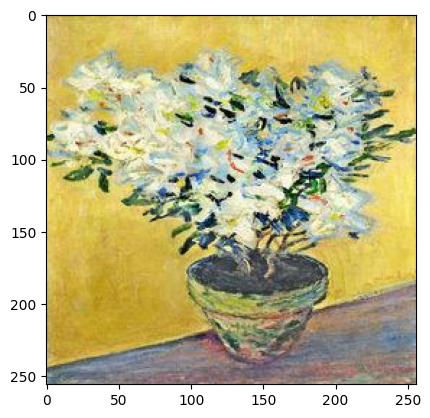

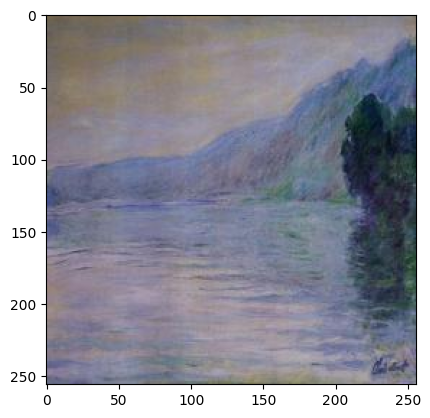

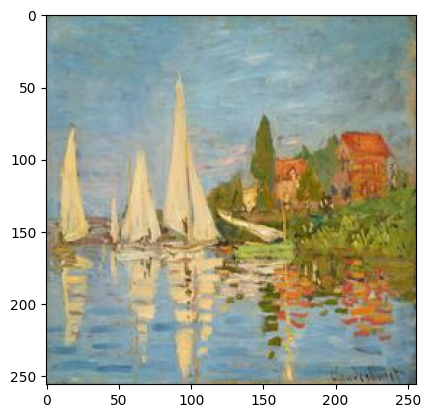

In [14]:
from random import choices
from PIL import Image

for sample_img in choices(monet_jpg_filepaths, k=3):
    plt.imshow(Image.open(sample_img))
    plt.show()

Let's inspect the non-monet images as well

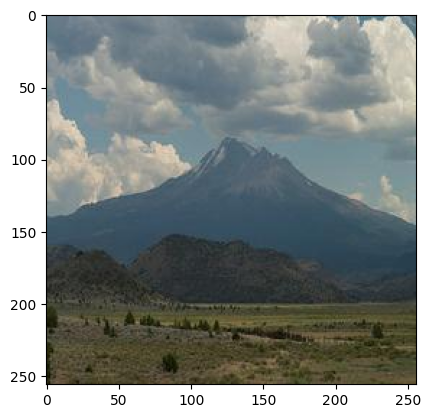

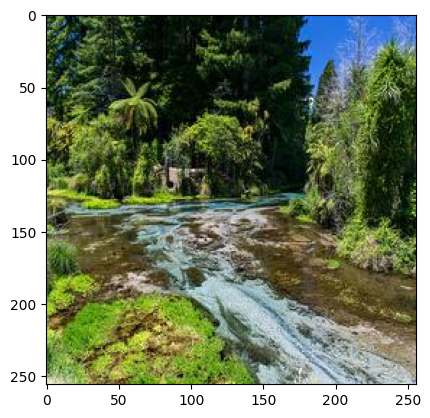

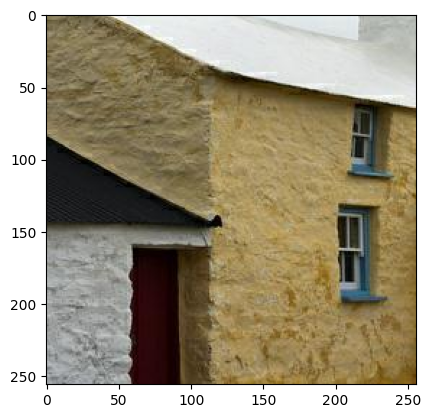

In [15]:

for sample_img in choices(photo_jpg_filepaths, k=3):
    plt.imshow(Image.open(sample_img))
    plt.show()

In [58]:
def mean_color_distribution(img_filepaths):
        
    mean_channel_values = {
        'R' : [],
        'G' : [],
        'B' : []
    }
    
    for img_path in tqdm(img_filepaths):
        for channel in mean_channel_values:
            img = Image.open(img_path)
            mean_channel_values[channel].append(np.array(img.getchannel(channel)).mean())
        

    df_rgb = pd.DataFrame(mean_channel_values)
    print(df_rgb.mean())
    print(df_rgb.std())
    df_rgb.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    sns.histplot(df_rgb['R'], bins=20, kde=True, label='R', color='red')
    sns.histplot(df_rgb['G'], bins=20, kde=True, label='G', color='green')
    sns.histplot(df_rgb['B'], bins=20, kde=True, label='B', color='blue')
    plt.legend()
    plt.show()

100%|██████████| 300/300 [00:01<00:00, 169.17it/s]
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


R    132.963005
G    133.727880
B    121.572679
dtype: float64
R    28.756461
G    28.997153
B    36.119315
dtype: float64


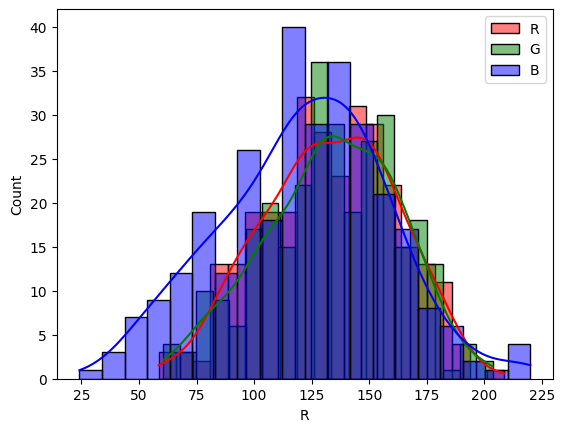

In [59]:
mean_color_distribution(monet_jpg_filepaths)

It's really interesting to see the color distribution shows a tendency for less blue color in monet paintings on average, but with much higher variance than the other colors. After looking it up I found the following relevant article:
https://www.forthepeoplecollective.org/monets-use-of-blue-in-his-paintings/

100%|██████████| 1000/1000 [00:07<00:00, 133.86it/s]
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


R    103.378406
G    105.254443
B     98.656072
dtype: float64
R    37.348568
G    35.837795
B    39.549403
dtype: float64


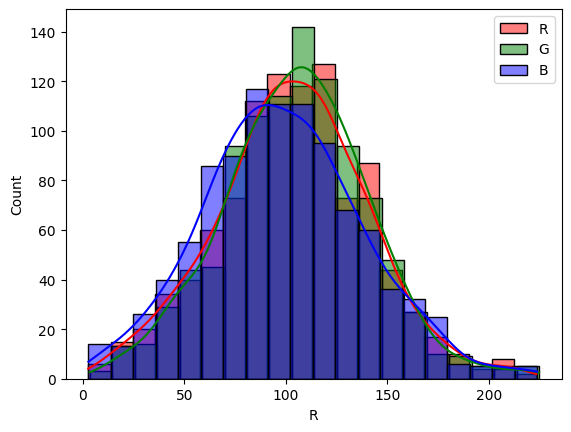

In [62]:
mean_color_distribution(choices(photo_jpg_filepaths,k=1000))

On the other hand, in a sampled set of the real photos the colors are a bit more balanced.

# Model Architecture

We will first test a vanilla GAN network, since our images are pretty large (256x256), we will attempt to generate a resized smaller version of them.

## Vanilla GAN

A vanilla GAN consists of two neural networks, a generator and a discriminator, competing with each other. The generator creates synthetic data, while the discriminator tries to distinguish between real and synthetic data.

We will start with simple fully connected networks for the generator and discriminator.

In [88]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Flatten(),
        
        layers.Dense(1024),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.5),
        
        layers.Dense(512),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.5),
        
        layers.Dense(256),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.5),
        
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator_dense",
)
discriminator.summary()

Model: "discriminator_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1024)                │       3,146,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,803,137 (14.51 MB)

 Trainable params: 3,803,137 (14.51 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        
        layers.Dense(8 * 8 * 16),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.2),

        layers.Dense(16 * 16 * 8),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.2),

        layers.Dense(32 * 32 * 3),
        layers.LeakyReLU(negative_slope=0.2),

        layers.Reshape((32,32,3))

        
    ],
    name="generator_dense",
)
generator.summary()

Model: "generator_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2048)                │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 3072)                │       6,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 32, 32, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,525,824 (32.52 MB)

 Trainable params: 8,525,824 (32.52 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, limit_d_loss=None):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)
        self.freeze_discriminator = False
        self.limit_d_loss = limit_d_loss

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    @tf.function
    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Train the discriminator
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors, training=True)


        with tf.GradientTape() as tape:
            # Calculate losses for discriminator
            generated_image_loss = self.loss_fn(ops.ones((batch_size, 1)), self.discriminator(generated_images,  training=True))
            real_image_loss = self.loss_fn(ops.zeros((batch_size, 1)), self.discriminator(real_images, training=True))

            d_loss = generated_image_loss + real_image_loss

            # Experimental conditional training, to avoid the discriminator throwing off the model
            if self.freeze_discriminator or (self.limit_d_loss and d_loss < self.limit_d_loss):
                pass # We're skipping the weights update in these cases that limit the discriminator
            else:
                grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

                self.d_optimizer.apply_gradients(
                    zip(grads, self.discriminator.trainable_weights)
                )

        # Train the generator

        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            discriminator_pred = self.discriminator(generated_images, training=True)
            g_loss = self.loss_fn(ops.zeros((batch_size, 1)), discriminator_pred)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [93]:
gan_preview_images_dir = './progress_images/'
if not os.path.exists(gan_preview_images_dir):
    os.makedirs(gan_preview_images_dir)


class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1, latent_dim=128, preview_freq=3):
        """
        A combined Keras callback to:
        1. Generate and save preview images every 'preview_freq' epochs
        2. Plot generator and discriminator losses every 'plot_interval' epochs

        Args:
            num_img (int): Number of preview images to generate per epoch.
            latent_dim (int): Latent dimension for the generator.
            preview_freq (int): Epoch frequency to generate preview images and loss plots.
        """
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.preview_freq = preview_freq
        self.seed_generator = keras.random.SeedGenerator(42)

        # Loss plotting components
        self.gen_losses = []
        self.disc_losses = []
        self.epoch_count = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1


        # Preview during training every few epochs
        if self.preview_freq and epoch % self.preview_freq == 0:
            # 1. Image Generation and Preview
            random_latent_vectors = keras.random.normal(
                shape=(self.num_img, self.latent_dim), seed=self.seed_generator
            )
            generated_images = self.model.generator(random_latent_vectors, training=False)

            # generated_images += 1
            # generated_images /= 2
            generated_images *= 255
            generated_images_np = generated_images.numpy() # Convert to numpy once

            for i in range(self.num_img):
                img = keras.utils.array_to_img(generated_images_np[i]).resize((256,256))
                #img.save(os.path.join(gan_preview_images_dir,f"generated_img_epoch_{epoch:03d}_img_{i:02d}.png"))
                display(img)

        # 2. Loss Plotting
            gen_loss = logs.get('g_loss')
            disc_loss = logs.get('d_loss')

            if gen_loss and disc_loss: # Check if losses are available
                self.gen_losses.append(gen_loss)
                self.disc_losses.append(disc_loss)
                self.plot_losses()

    def plot_losses(self):
        plt.figure(figsize=(5, 3))
        plt.plot(self.gen_losses, label='Generator Loss')
        plt.plot(self.disc_losses, label='Discriminator Loss')
        plt.xlabel(f'Epochs (x{self.preview_freq})')
        plt.ylabel('Loss')
        plt.title('GAN Loss During Training')
        plt.legend()
        plt.grid(True)
        #plt.savefig('gan_loss_plot_epochs.png')
        plt.show()


In [94]:
batch_size = 32

In [95]:
dataset = keras.utils.image_dataset_from_directory(
    os.path.join(INPUT_BASEPATH,'monet_jpg'),
    labels=None,
    shuffle=True,
    batch_size=batch_size,
    image_size=(32,32),
)

Found 300 files.


In [101]:
g_lr = 2e-4
d_lr = 2e-4

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#########################
#gan.freeze_discriminator = True # Testing
#########################

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=d_lr, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=g_lr, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [102]:
#checkpoint_dir = './gan_checkpoints'
#checkpoint_callback = keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir,'dcgan_checkpoint.model.keras'), save_freq='epoch')

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - d_loss: 0.5905 - g_loss: 1.4521

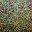

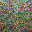

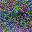

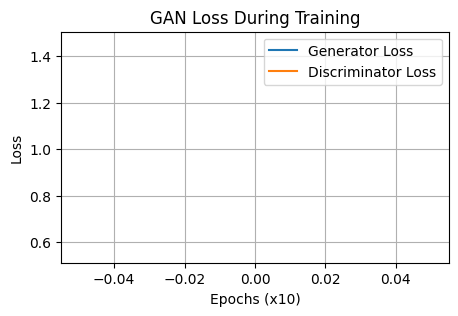

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - d_loss: 0.5875 - g_loss: 1.4529
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.5731 - g_loss: 1.3189
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - d_loss: 0.6445 - g_loss: 1.3361
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - d_loss: 0.6203 - g_loss: 1.4014
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 0.6288 - g_loss: 1.4361
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.5787 - g_loss: 1.3871
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 0.7649 - g_loss: 1.3331
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.6319 - g_loss: 1.3777
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - d_loss: 0.6110 - g_loss: 1.3556
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 0.8329 - g_loss: 1.2089
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - d_loss: 0.5778 - g_loss: 1.3137

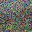

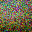

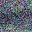

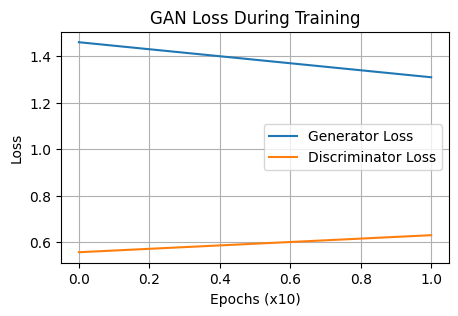

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - d_loss: 0.5826 - g_loss: 1.3133
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 0.5710 - g_loss: 1.2118
Epoch 13/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - d_loss: 0.5946 - g_loss: 1.2731
Epoch 14/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 0.7952 - g_loss: 1.3056
Epoch 15/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - d_loss: 0.5325 - g_loss: 1.2894
Epoch 16/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 0.7918 - g_loss: 1.2093
Epoch 17/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 0.6761 - g_loss: 1.1621
Epoch 18/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - d_loss: 0.6130 - g_loss: 1.3321
Epoch 19/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 0.6403 - g_loss: 1.3321
Epoch 20/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - d_loss: 0.7126 - g_loss: 1.3560
Epoch 21/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - d_loss: 0.5106 - g_loss: 1.3597

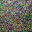

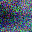

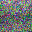

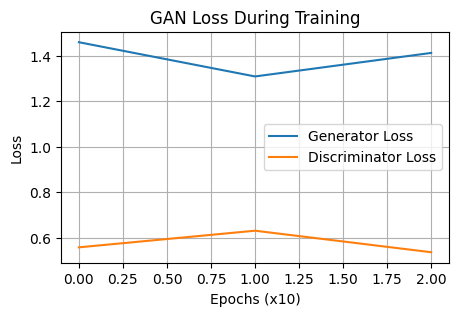

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - d_loss: 0.5130 - g_loss: 1.3646
Epoch 22/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 0.7293 - g_loss: 1.2462
Epoch 23/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - d_loss: 0.7051 - g_loss: 1.2631
Epoch 24/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 0.6415 - g_loss: 1.2244
Epoch 25/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.6152 - g_loss: 1.2675
Epoch 26/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - d_loss: 0.5930 - g_loss: 1.3135
Epoch 27/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - d_loss: 0.6002 - g_loss: 1.3970
Epoch 28/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 0.6096 - g_loss: 1.4034
Epoch 29/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 0.5820 - g_loss: 1.4237
Epoch 30/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 0.6023 - g_loss: 1.3448
Epoch 31/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - d_loss: 0.6099 - g_loss: 1.3451

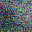

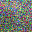

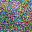

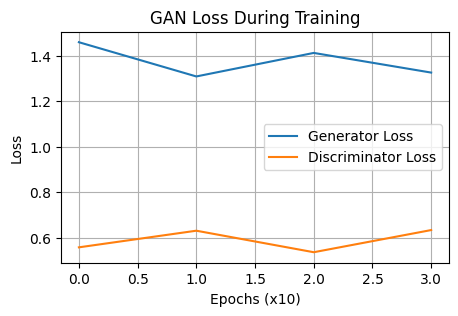

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - d_loss: 0.6121 - g_loss: 1.3434
Epoch 32/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - d_loss: 0.7682 - g_loss: 1.4006
Epoch 33/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - d_loss: 0.7243 - g_loss: 1.3148
Epoch 34/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - d_loss: 0.7663 - g_loss: 1.3187
Epoch 35/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 0.6830 - g_loss: 1.2120
Epoch 36/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 0.7766 - g_loss: 1.2471
Epoch 37/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - d_loss: 0.6097 - g_loss: 1.2914
Epoch 38/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - d_loss: 0.7377 - g_loss: 1.3577
Epoch 39/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - d_loss: 0.5796 - g_loss: 1.3481
Epoch 40/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.8602 - g_loss: 1.5249
Epoch 41/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - d_loss: 0.5803 - g_loss: 1.3786

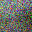

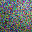

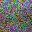

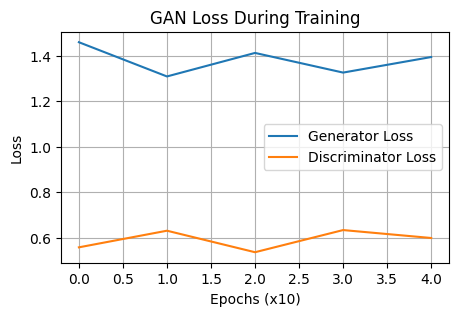

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - d_loss: 0.5820 - g_loss: 1.3801
Epoch 42/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - d_loss: 0.6529 - g_loss: 1.3351
Epoch 43/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - d_loss: 0.6652 - g_loss: 1.3883
Epoch 44/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - d_loss: 0.5935 - g_loss: 1.4339
Epoch 45/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 0.7983 - g_loss: 1.2430
Epoch 46/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - d_loss: 0.5645 - g_loss: 1.4793
Epoch 47/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - d_loss: 1.0869 - g_loss: 1.1236
Epoch 48/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 0.5995 - g_loss: 1.4610
Epoch 49/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - d_loss: 0.6182 - g_loss: 1.3366
Epoch 50/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 0.7344 - g_loss: 1.3088
Epoch 51/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - d_loss: 0.5734 - g_loss: 1.3099

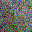

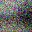

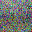

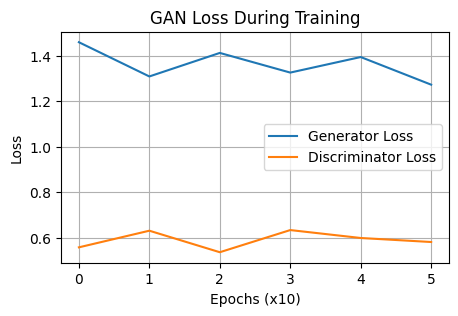

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - d_loss: 0.5741 - g_loss: 1.3066
Epoch 52/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 0.6834 - g_loss: 1.2427
Epoch 53/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 0.6373 - g_loss: 1.2920
Epoch 54/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 0.6554 - g_loss: 1.2225
Epoch 55/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - d_loss: 0.5668 - g_loss: 1.3075
Epoch 56/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.6014 - g_loss: 1.2849
Epoch 57/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - d_loss: 0.5988 - g_loss: 1.4038
Epoch 58/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - d_loss: 0.6084 - g_loss: 1.3027
Epoch 59/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 0.5836 - g_loss: 1.3690
Epoch 60/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 0.6984 - g_loss: 1.3638
Epoch 61/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - d_loss: 0.6334 - g_loss: 1.3378

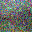

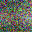

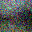

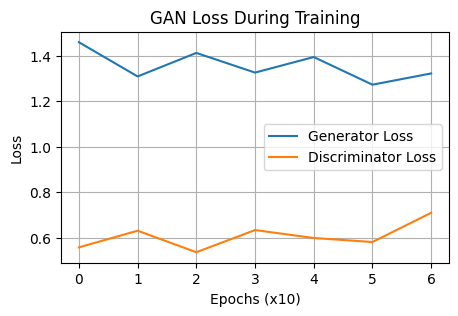

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - d_loss: 0.6404 - g_loss: 1.3364
Epoch 62/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 0.8408 - g_loss: 1.3222
Epoch 63/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - d_loss: 0.5886 - g_loss: 1.3184
Epoch 64/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - d_loss: 0.9455 - g_loss: 1.3801
Epoch 65/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - d_loss: 0.6011 - g_loss: 1.3591
Epoch 66/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - d_loss: 0.6300 - g_loss: 1.4295
Epoch 67/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - d_loss: 0.8522 - g_loss: 1.4575
Epoch 68/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - d_loss: 0.6507 - g_loss: 1.2029
Epoch 69/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 0.6997 - g_loss: 1.2391
Epoch 70/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.6998 - g_loss: 1.1898
Epoch 71/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - d_loss: 0.6825 - g_loss: 1.2862

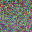

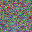

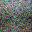

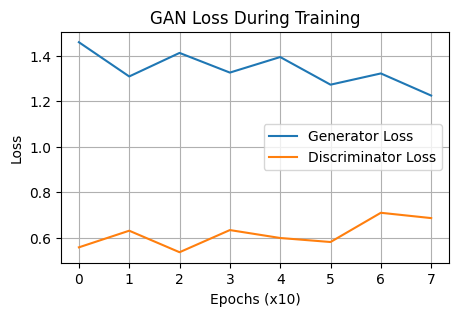

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - d_loss: 0.6828 - g_loss: 1.2806
Epoch 72/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 0.6484 - g_loss: 1.1925
Epoch 73/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - d_loss: 0.8370 - g_loss: 1.0998
Epoch 74/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - d_loss: 0.7943 - g_loss: 1.1688
Epoch 75/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - d_loss: 0.7115 - g_loss: 1.2748
Epoch 76/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.7689 - g_loss: 1.1947
Epoch 77/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 0.7104 - g_loss: 1.3285
Epoch 78/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 0.7275 - g_loss: 1.3190
Epoch 79/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - d_loss: 0.6662 - g_loss: 1.3636
Epoch 80/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 0.7622 - g_loss: 1.2022
Epoch 81/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - d_loss: 0.7926 - g_loss: 1.1794

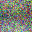

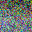

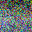

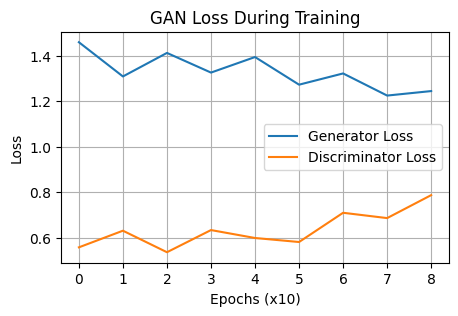

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - d_loss: 0.7921 - g_loss: 1.1854
Epoch 82/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 0.7070 - g_loss: 1.2680
Epoch 83/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - d_loss: 0.6771 - g_loss: 1.3954
Epoch 84/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 0.8178 - g_loss: 1.2104
Epoch 85/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - d_loss: 0.7336 - g_loss: 1.2527
Epoch 86/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 0.6849 - g_loss: 1.2909
Epoch 87/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - d_loss: 0.7996 - g_loss: 1.4253
Epoch 88/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 0.7656 - g_loss: 1.2507
Epoch 89/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 0.7931 - g_loss: 1.1651
Epoch 90/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 0.8156 - g_loss: 1.1834
Epoch 91/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - d_loss: 0.7133 - g_loss: 1.2022

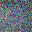

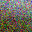

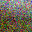

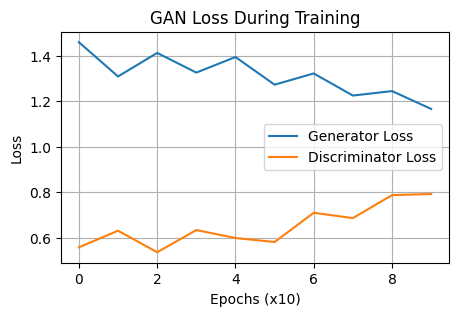

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - d_loss: 0.7205 - g_loss: 1.1989
Epoch 92/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - d_loss: 0.8556 - g_loss: 1.1513
Epoch 93/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 0.7758 - g_loss: 1.1393
Epoch 94/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.7718 - g_loss: 1.0547
Epoch 95/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - d_loss: 0.8209 - g_loss: 1.1362
Epoch 96/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 0.7247 - g_loss: 1.2478
Epoch 97/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 0.7660 - g_loss: 1.1897
Epoch 98/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 0.8646 - g_loss: 1.1385
Epoch 99/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.8507 - g_loss: 1.1438
Epoch 100/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - d_loss: 0.7611 - g_loss: 1.1769
Epoch 101/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - d_loss: 0.8610 - g_loss: 1.2140

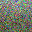

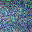

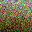

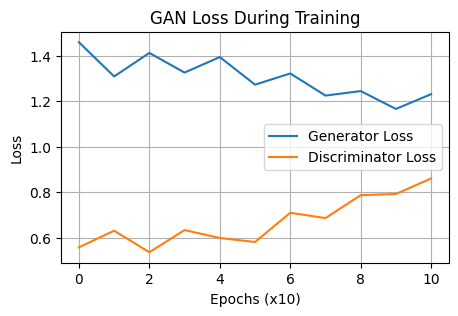

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - d_loss: 0.8609 - g_loss: 1.2156
Epoch 102/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - d_loss: 0.7379 - g_loss: 1.1733
Epoch 103/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 0.8008 - g_loss: 1.1642
Epoch 104/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 0.7862 - g_loss: 1.2252
Epoch 105/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 0.9406 - g_loss: 1.1309
Epoch 106/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.8775 - g_loss: 1.2803
Epoch 107/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 0.8066 - g_loss: 1.3922
Epoch 108/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.0967 - g_loss: 1.1462
Epoch 109/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 0.7838 - g_loss: 1.4018
Epoch 110/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 0.8009 - g_loss: 1.3501
Epoch 111/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - d_loss: 0.9081 - g_loss: 1.4579

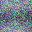

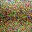

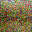

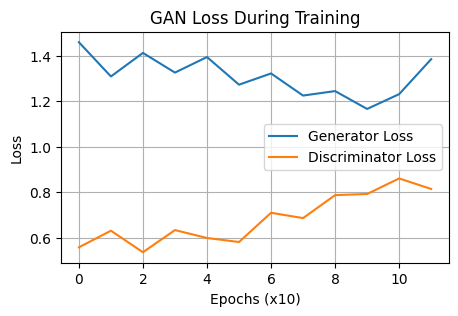

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - d_loss: 0.8996 - g_loss: 1.4514
Epoch 112/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 0.9023 - g_loss: 1.2193
Epoch 113/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 0.8531 - g_loss: 1.4095
Epoch 114/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 0.7936 - g_loss: 1.3321
Epoch 115/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 0.8082 - g_loss: 1.4696
Epoch 116/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 0.9096 - g_loss: 1.4373
Epoch 117/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 0.7762 - g_loss: 1.3800
Epoch 118/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 0.7993 - g_loss: 1.3553
Epoch 119/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - d_loss: 0.8312 - g_loss: 1.3351
Epoch 120/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 0.8092 - g_loss: 1.3137
Epoch 121/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - d_loss: 0.7783 - g_loss: 1.4348

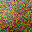

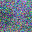

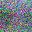

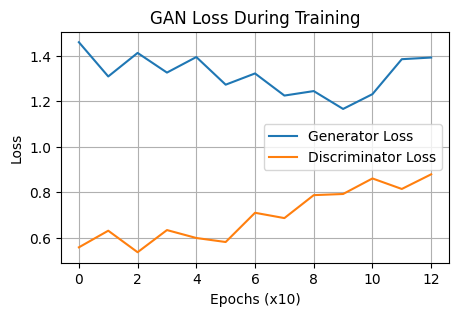

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - d_loss: 0.7875 - g_loss: 1.4310
Epoch 122/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - d_loss: 0.9119 - g_loss: 1.0988
Epoch 123/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 0.8959 - g_loss: 1.4643
Epoch 124/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 0.8247 - g_loss: 1.2760
Epoch 125/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.0880 - g_loss: 1.3520
Epoch 126/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - d_loss: 0.9414 - g_loss: 1.3717
Epoch 127/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - d_loss: 0.8714 - g_loss: 1.3215
Epoch 128/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 0.9351 - g_loss: 1.1160
Epoch 129/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 0.9757 - g_loss: 1.2413
Epoch 130/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 0.9452 - g_loss: 1.3642
Epoch 131/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - d_loss: 0.9360 - g_loss: 1.1203

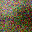

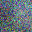

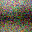

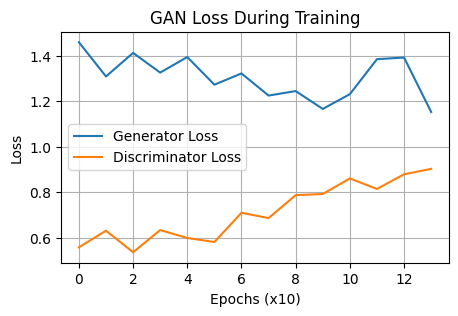

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - d_loss: 0.9330 - g_loss: 1.1233
Epoch 132/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 0.8593 - g_loss: 1.3849
Epoch 133/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 0.9349 - g_loss: 1.2177
Epoch 134/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - d_loss: 0.7716 - g_loss: 1.1904
Epoch 135/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 0.8866 - g_loss: 1.3388
Epoch 136/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 0.8756 - g_loss: 1.2765
Epoch 137/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 0.8768 - g_loss: 1.3964
Epoch 138/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 0.8859 - g_loss: 1.3969
Epoch 139/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - d_loss: 0.8401 - g_loss: 1.4980
Epoch 140/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - d_loss: 0.8919 - g_loss: 1.2853
Epoch 141/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - d_loss: 0.8540 - g_loss: 1.4890

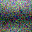

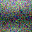

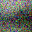

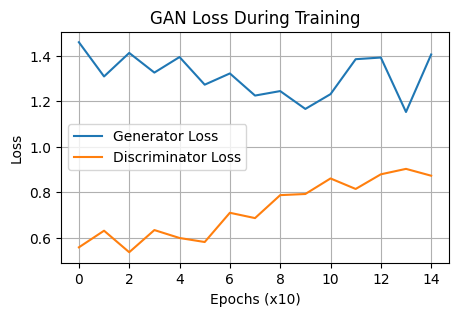

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - d_loss: 0.8557 - g_loss: 1.4815
Epoch 142/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 0.9362 - g_loss: 1.3575
Epoch 143/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 0.9175 - g_loss: 1.3083
Epoch 144/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 0.8447 - g_loss: 1.3288
Epoch 145/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - d_loss: 0.8907 - g_loss: 1.4164
Epoch 146/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 0.8915 - g_loss: 1.2658
Epoch 147/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - d_loss: 1.0916 - g_loss: 1.3415
Epoch 148/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 0.9361 - g_loss: 1.3187
Epoch 149/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.0587 - g_loss: 1.2645
Epoch 150/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - d_loss: 0.8985 - g_loss: 1.2896
Epoch 151/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - d_loss: 0.9605 - g_loss: 1.2585

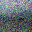

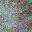

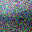

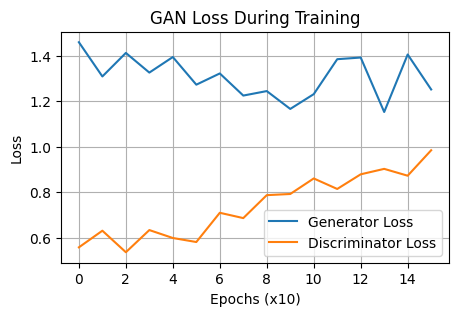

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - d_loss: 0.9627 - g_loss: 1.2579
Epoch 152/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - d_loss: 0.9812 - g_loss: 1.1356
Epoch 153/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.0570 - g_loss: 1.0732
Epoch 154/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - d_loss: 1.0646 - g_loss: 1.1911
Epoch 155/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - d_loss: 1.1071 - g_loss: 1.2575
Epoch 156/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 0.9992 - g_loss: 1.2399
Epoch 157/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - d_loss: 1.2753 - g_loss: 1.2505
Epoch 158/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - d_loss: 1.0167 - g_loss: 1.0763
Epoch 159/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.1413 - g_loss: 1.0266
Epoch 160/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - d_loss: 1.0544 - g_loss: 1.2723
Epoch 161/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - d_loss: 1.0888 - g_loss: 1.3329

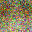

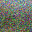

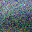

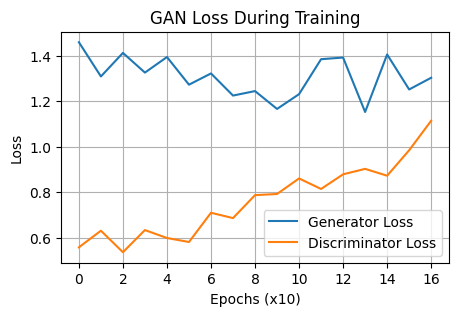

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - d_loss: 1.0911 - g_loss: 1.3303
Epoch 162/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.0466 - g_loss: 1.0891
Epoch 163/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - d_loss: 1.1280 - g_loss: 1.3017
Epoch 164/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 1.0071 - g_loss: 1.1709
Epoch 165/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 0.9949 - g_loss: 1.1938
Epoch 166/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - d_loss: 1.1667 - g_loss: 1.2528
Epoch 167/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - d_loss: 1.0638 - g_loss: 1.2253
Epoch 168/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.1240 - g_loss: 1.2609
Epoch 169/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 1.0644 - g_loss: 1.3686
Epoch 170/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - d_loss: 1.1214 - g_loss: 1.1905
Epoch 171/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - d_loss: 1.0511 - g_loss: 1.2808

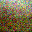

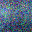

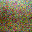

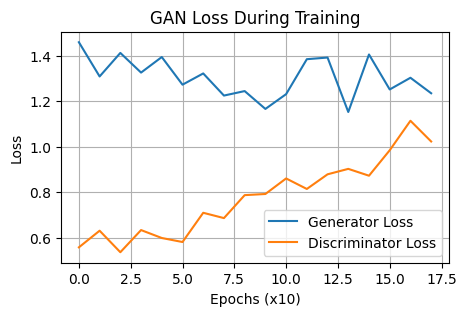

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - d_loss: 1.0486 - g_loss: 1.2767
Epoch 172/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - d_loss: 1.0460 - g_loss: 1.3997
Epoch 173/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - d_loss: 1.1132 - g_loss: 1.4360
Epoch 174/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.1844 - g_loss: 1.2810
Epoch 175/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - d_loss: 1.0011 - g_loss: 1.5557
Epoch 176/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - d_loss: 1.1562 - g_loss: 1.5605
Epoch 177/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 0.9915 - g_loss: 1.2287
Epoch 178/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - d_loss: 0.9879 - g_loss: 1.2878
Epoch 179/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 0.9861 - g_loss: 1.2566
Epoch 180/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.0024 - g_loss: 1.3781
Epoch 181/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - d_loss: 0.9367 - g_loss: 1.5733

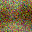

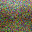

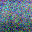

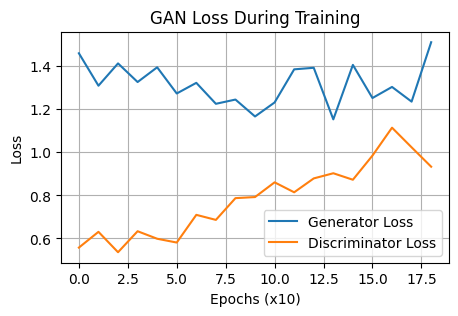

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - d_loss: 0.9364 - g_loss: 1.5677
Epoch 182/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 0.9052 - g_loss: 1.4170
Epoch 183/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 0.9533 - g_loss: 1.5731
Epoch 184/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 0.9729 - g_loss: 1.4755
Epoch 185/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - d_loss: 1.0233 - g_loss: 1.3789
Epoch 186/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 1.0365 - g_loss: 1.4487
Epoch 187/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - d_loss: 0.8585 - g_loss: 1.4740
Epoch 188/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 1.1379 - g_loss: 1.4621
Epoch 189/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 0.9687 - g_loss: 1.4007
Epoch 190/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.1717 - g_loss: 1.1462
Epoch 191/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - d_loss: 0.9304 - g_loss: 1.2760

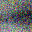

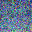

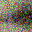

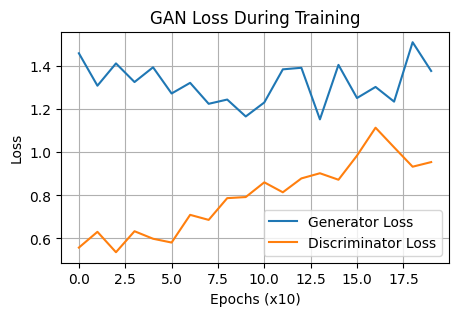

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - d_loss: 0.9326 - g_loss: 1.2853
Epoch 192/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - d_loss: 0.8985 - g_loss: 1.4285
Epoch 193/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 0.9614 - g_loss: 1.3985
Epoch 194/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 1.0070 - g_loss: 1.0368
Epoch 195/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - d_loss: 1.1670 - g_loss: 1.3883
Epoch 196/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 1.1773 - g_loss: 1.3287
Epoch 197/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 0.8815 - g_loss: 1.4891
Epoch 198/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 1.2923 - g_loss: 1.2925
Epoch 199/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 0.9445 - g_loss: 1.4779
Epoch 200/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - d_loss: 1.0616 - g_loss: 1.2827
Epoch 201/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - d_loss: 1.0947 - g_loss: 1.4470

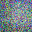

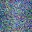

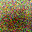

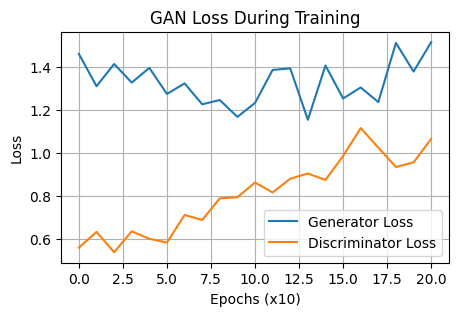

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - d_loss: 1.0919 - g_loss: 1.4532
Epoch 202/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 0.9660 - g_loss: 1.2235
Epoch 203/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - d_loss: 1.0338 - g_loss: 1.1962
Epoch 204/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 0.9617 - g_loss: 1.3823
Epoch 205/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - d_loss: 1.0409 - g_loss: 1.2296
Epoch 206/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 0.9909 - g_loss: 1.4118
Epoch 207/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.0964 - g_loss: 1.4223
Epoch 208/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 1.0830 - g_loss: 1.3631
Epoch 209/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - d_loss: 1.0138 - g_loss: 1.2623
Epoch 210/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - d_loss: 1.0852 - g_loss: 1.3473
Epoch 211/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - d_loss: 0.9358 - g_loss: 1.4015

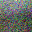

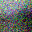

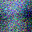

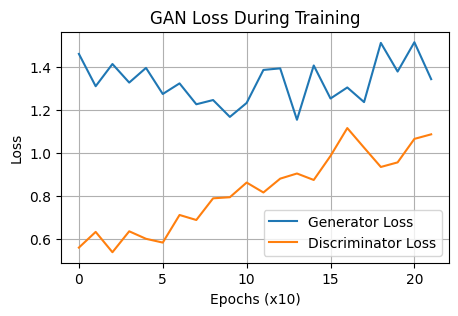

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - d_loss: 0.9494 - g_loss: 1.3961
Epoch 212/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 0.8873 - g_loss: 1.4848
Epoch 213/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 1.0920 - g_loss: 1.2366
Epoch 214/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - d_loss: 0.9199 - g_loss: 1.5979
Epoch 215/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.0126 - g_loss: 1.2101
Epoch 216/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.1652 - g_loss: 1.3021
Epoch 217/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - d_loss: 0.9890 - g_loss: 1.2849
Epoch 218/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 0.9336 - g_loss: 1.4576
Epoch 219/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 1.1656 - g_loss: 1.2024
Epoch 220/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 1.0163 - g_loss: 1.3570
Epoch 221/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - d_loss: 1.1840 - g_loss: 0.9962

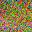

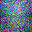

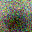

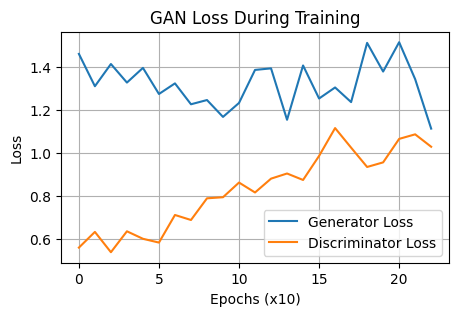

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - d_loss: 1.1698 - g_loss: 1.0068
Epoch 222/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 0.9426 - g_loss: 1.1073
Epoch 223/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - d_loss: 1.0891 - g_loss: 1.2696
Epoch 224/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.1550 - g_loss: 1.3907
Epoch 225/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.0501 - g_loss: 1.2356
Epoch 226/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.0974 - g_loss: 1.5786
Epoch 227/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - d_loss: 1.0586 - g_loss: 1.0814
Epoch 228/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - d_loss: 0.9342 - g_loss: 1.5562
Epoch 229/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 0.9768 - g_loss: 1.2585
Epoch 230/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - d_loss: 1.0600 - g_loss: 1.3151
Epoch 231/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - d_loss: 1.0571 - g_loss: 1.4178

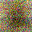

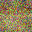

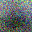

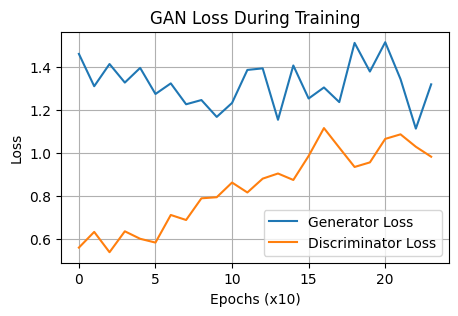

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - d_loss: 1.0502 - g_loss: 1.4087
Epoch 232/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.0221 - g_loss: 1.2569
Epoch 233/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 0.9046 - g_loss: 1.3157
Epoch 234/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - d_loss: 1.2017 - g_loss: 1.3665
Epoch 235/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 0.9805 - g_loss: 1.3493
Epoch 236/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 0.9533 - g_loss: 1.2496
Epoch 237/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - d_loss: 1.0309 - g_loss: 1.3374
Epoch 238/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - d_loss: 1.0315 - g_loss: 1.3816
Epoch 239/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.0921 - g_loss: 1.3224
Epoch 240/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - d_loss: 1.1152 - g_loss: 1.1952
Epoch 241/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - d_loss: 1.1470 - g_loss: 1.1193

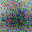

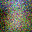

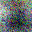

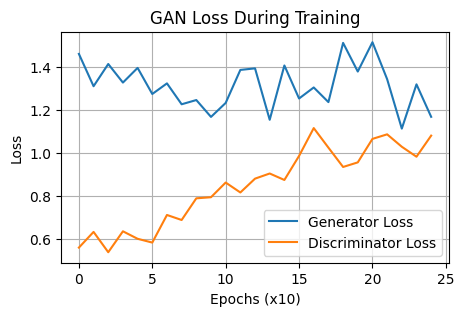

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - d_loss: 1.1408 - g_loss: 1.1236
Epoch 242/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - d_loss: 1.1297 - g_loss: 1.2598
Epoch 243/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - d_loss: 1.0704 - g_loss: 1.3494
Epoch 244/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - d_loss: 1.2158 - g_loss: 1.3778
Epoch 245/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - d_loss: 1.1475 - g_loss: 1.3853
Epoch 246/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 1.0819 - g_loss: 1.1801
Epoch 247/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - d_loss: 1.2149 - g_loss: 1.1176
Epoch 248/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.3373 - g_loss: 1.0386
Epoch 249/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - d_loss: 1.2439 - g_loss: 1.0518
Epoch 250/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - d_loss: 1.2678 - g_loss: 1.0735
Epoch 251/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - d_loss: 1.2771 - g_loss: 1.1082

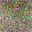

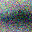

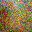

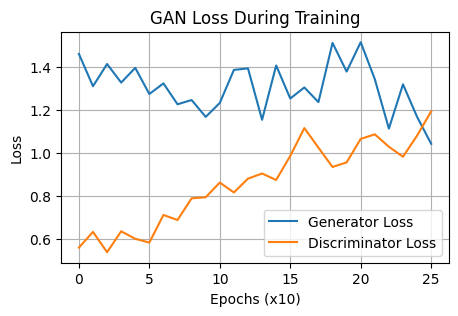

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - d_loss: 1.2694 - g_loss: 1.1021
Epoch 252/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - d_loss: 1.2993 - g_loss: 1.2061
Epoch 253/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.3128 - g_loss: 1.0182
Epoch 254/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.3373 - g_loss: 1.0311
Epoch 255/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - d_loss: 1.4073 - g_loss: 1.1539
Epoch 256/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.4898 - g_loss: 1.0262
Epoch 257/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - d_loss: 1.3540 - g_loss: 1.0413
Epoch 258/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 1.3532 - g_loss: 0.9578
Epoch 259/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - d_loss: 1.4487 - g_loss: 1.1784
Epoch 260/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.4945 - g_loss: 1.0311
Epoch 261/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - d_loss: 1.2867 - g_loss: 1.0531

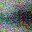

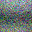

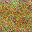

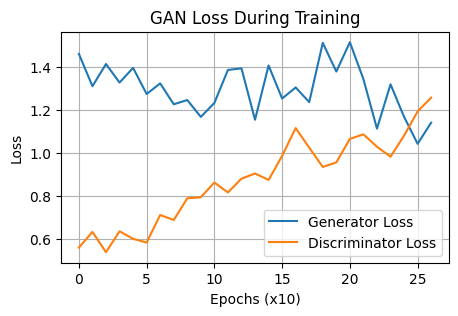

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - d_loss: 1.2840 - g_loss: 1.0610
Epoch 262/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 1.4385 - g_loss: 1.0788
Epoch 263/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.4553 - g_loss: 1.3028
Epoch 264/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.3465 - g_loss: 1.0492
Epoch 265/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - d_loss: 1.3657 - g_loss: 0.9182
Epoch 266/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 1.3898 - g_loss: 1.1595
Epoch 267/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - d_loss: 1.5280 - g_loss: 1.1357
Epoch 268/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - d_loss: 1.6357 - g_loss: 1.4237
Epoch 269/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.3955 - g_loss: 1.0665
Epoch 270/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - d_loss: 1.5758 - g_loss: 1.1063
Epoch 271/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - d_loss: 1.5120 - g_loss: 1.1658

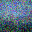

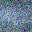

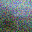

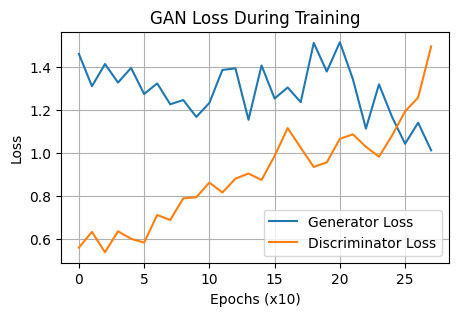

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - d_loss: 1.5105 - g_loss: 1.1517
Epoch 272/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - d_loss: 1.4379 - g_loss: 0.9624
Epoch 273/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.4541 - g_loss: 1.0299
Epoch 274/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.6426 - g_loss: 1.1595
Epoch 275/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - d_loss: 1.5034 - g_loss: 1.2055
Epoch 276/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.5613 - g_loss: 1.0344
Epoch 277/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.5487 - g_loss: 1.2531
Epoch 278/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - d_loss: 1.5587 - g_loss: 1.0307
Epoch 279/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - d_loss: 1.4886 - g_loss: 1.2153
Epoch 280/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - d_loss: 1.7636 - g_loss: 1.1639
Epoch 281/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - d_loss: 1.5100 - g_loss: 1.0582

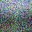

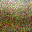

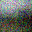

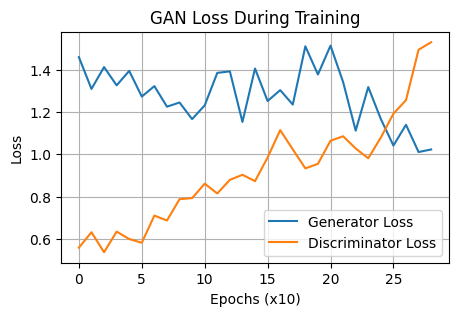

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - d_loss: 1.5119 - g_loss: 1.0550
Epoch 282/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.4484 - g_loss: 1.0784
Epoch 283/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 1.4532 - g_loss: 1.1693
Epoch 284/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - d_loss: 1.5632 - g_loss: 1.1726
Epoch 285/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - d_loss: 1.6938 - g_loss: 1.0669
Epoch 286/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 1.5694 - g_loss: 0.9722
Epoch 287/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.5597 - g_loss: 1.3428
Epoch 288/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.6301 - g_loss: 1.1754
Epoch 289/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.5027 - g_loss: 1.3308
Epoch 290/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.6759 - g_loss: 1.2483
Epoch 291/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - d_loss: 1.5833 - g_loss: 1.2546

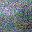

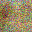

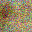

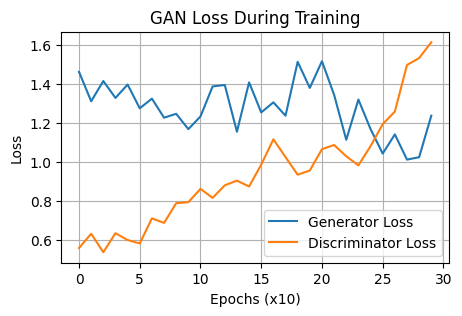

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - d_loss: 1.5859 - g_loss: 1.2529
Epoch 292/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 1.6200 - g_loss: 1.2935
Epoch 293/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - d_loss: 1.5801 - g_loss: 1.2452
Epoch 294/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - d_loss: 1.6660 - g_loss: 1.1326
Epoch 295/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - d_loss: 1.5515 - g_loss: 1.0979
Epoch 296/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - d_loss: 1.6171 - g_loss: 1.2241
Epoch 297/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.5273 - g_loss: 1.2971
Epoch 298/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.6957 - g_loss: 1.1430
Epoch 299/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.6493 - g_loss: 1.1583
Epoch 300/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - d_loss: 1.6190 - g_loss: 1.1820
Epoch 301/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - d_loss: 1.6200 - g_loss: 1.2887

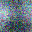

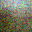

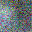

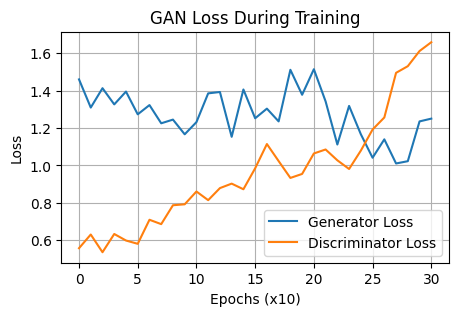

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - d_loss: 1.6235 - g_loss: 1.2852
Epoch 302/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - d_loss: 1.7352 - g_loss: 1.1303
Epoch 303/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - d_loss: 1.9313 - g_loss: 1.0583
Epoch 304/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.5679 - g_loss: 1.1404
Epoch 305/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - d_loss: 1.6239 - g_loss: 1.1116
Epoch 306/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.5235 - g_loss: 1.0426
Epoch 307/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - d_loss: 1.4103 - g_loss: 1.2133
Epoch 308/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - d_loss: 1.6554 - g_loss: 1.5289
Epoch 309/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.6103 - g_loss: 1.2362
Epoch 310/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.5874 - g_loss: 1.3365
Epoch 311/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - d_loss: 1.6084 - g_loss: 1.3346

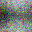

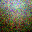

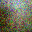

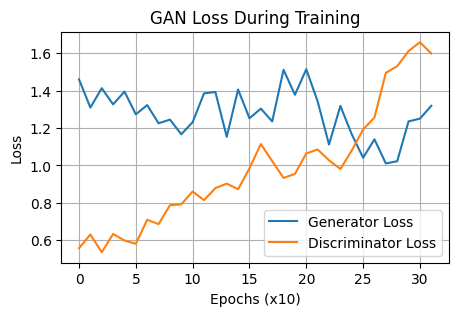

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - d_loss: 1.6075 - g_loss: 1.3332
Epoch 312/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 1.5841 - g_loss: 1.3430
Epoch 313/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - d_loss: 1.5214 - g_loss: 1.4665
Epoch 314/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - d_loss: 1.4394 - g_loss: 1.3042
Epoch 315/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - d_loss: 1.5270 - g_loss: 1.2821
Epoch 316/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 1.5356 - g_loss: 1.5172
Epoch 317/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 1.5015 - g_loss: 1.3714
Epoch 318/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 1.5184 - g_loss: 1.2130
Epoch 319/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 1.3918 - g_loss: 1.4809
Epoch 320/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.4353 - g_loss: 1.5166
Epoch 321/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - d_loss: 1.5451 - g_loss: 1.4876

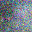

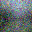

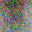

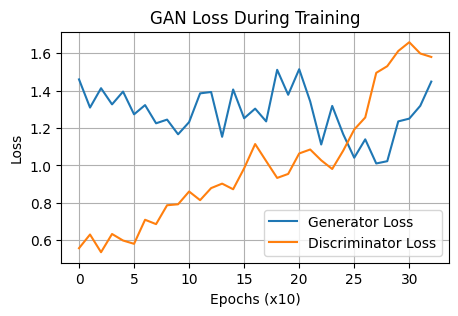

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - d_loss: 1.5483 - g_loss: 1.4840
Epoch 322/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 1.4766 - g_loss: 1.5300
Epoch 323/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.4329 - g_loss: 1.2625
Epoch 324/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.3524 - g_loss: 1.3365
Epoch 325/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.4580 - g_loss: 1.4863
Epoch 326/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.3803 - g_loss: 1.3408
Epoch 327/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.4929 - g_loss: 1.5252
Epoch 328/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.6976 - g_loss: 1.3596
Epoch 329/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 1.5610 - g_loss: 1.3949
Epoch 330/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.5495 - g_loss: 1.1196
Epoch 331/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - d_loss: 1.6369 - g_loss: 1.4666

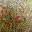

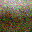

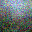

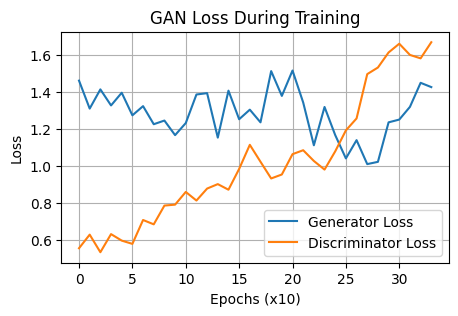

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - d_loss: 1.6396 - g_loss: 1.4628
Epoch 332/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - d_loss: 1.5800 - g_loss: 1.2310
Epoch 333/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.6252 - g_loss: 1.0439
Epoch 334/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.4126 - g_loss: 1.1769
Epoch 335/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - d_loss: 1.4713 - g_loss: 1.1952
Epoch 336/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 1.5572 - g_loss: 1.2050
Epoch 337/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.4998 - g_loss: 1.0503
Epoch 338/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - d_loss: 1.5751 - g_loss: 1.1932
Epoch 339/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - d_loss: 1.5410 - g_loss: 1.1545
Epoch 340/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - d_loss: 1.4704 - g_loss: 0.9414
Epoch 341/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - d_loss: 1.6409 - g_loss: 1.3736

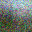

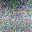

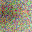

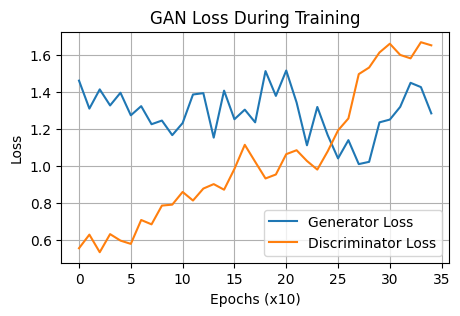

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - d_loss: 1.6418 - g_loss: 1.3655
Epoch 342/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.7029 - g_loss: 1.5388
Epoch 343/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.4476 - g_loss: 1.3905
Epoch 344/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.6933 - g_loss: 1.5240
Epoch 345/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 1.6390 - g_loss: 1.1723
Epoch 346/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - d_loss: 1.7790 - g_loss: 1.1885
Epoch 347/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.6375 - g_loss: 1.1233
Epoch 348/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.4673 - g_loss: 1.1861
Epoch 349/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - d_loss: 1.5751 - g_loss: 1.5208
Epoch 350/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - d_loss: 1.5142 - g_loss: 1.4011
Epoch 351/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - d_loss: 1.5312 - g_loss: 1.2284

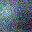

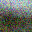

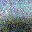

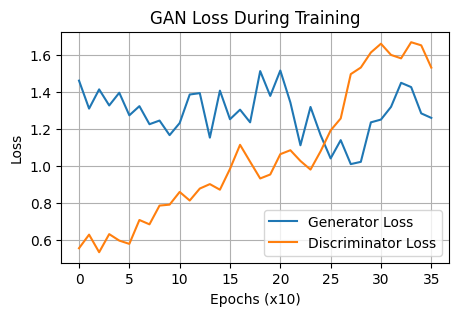

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - d_loss: 1.5312 - g_loss: 1.2312
Epoch 352/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 1.4800 - g_loss: 1.1476
Epoch 353/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.4405 - g_loss: 1.2918
Epoch 354/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - d_loss: 1.5141 - g_loss: 1.2269
Epoch 355/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 1.5846 - g_loss: 1.0818
Epoch 356/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - d_loss: 1.3812 - g_loss: 1.4345
Epoch 357/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - d_loss: 1.4267 - g_loss: 1.4824
Epoch 358/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - d_loss: 1.9019 - g_loss: 1.4369
Epoch 359/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.5568 - g_loss: 1.3422
Epoch 360/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.4985 - g_loss: 1.5301
Epoch 361/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - d_loss: 1.4657 - g_loss: 1.3690

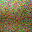

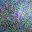

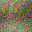

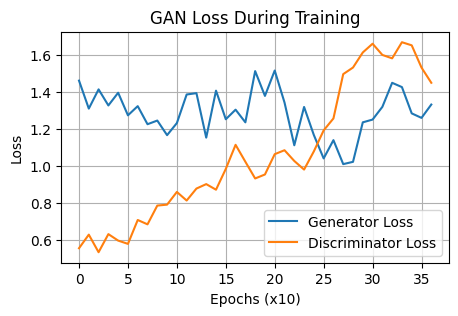

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - d_loss: 1.4642 - g_loss: 1.3656
Epoch 362/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.7450 - g_loss: 1.2026
Epoch 363/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - d_loss: 1.4032 - g_loss: 1.1919
Epoch 364/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.5849 - g_loss: 1.3068
Epoch 365/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.4475 - g_loss: 1.3858
Epoch 366/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 1.4566 - g_loss: 1.3781
Epoch 367/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - d_loss: 1.4982 - g_loss: 1.4391
Epoch 368/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - d_loss: 1.4263 - g_loss: 1.3250
Epoch 369/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 1.4530 - g_loss: 1.2501
Epoch 370/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.4315 - g_loss: 1.1886
Epoch 371/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - d_loss: 1.5634 - g_loss: 1.3640

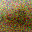

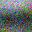

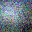

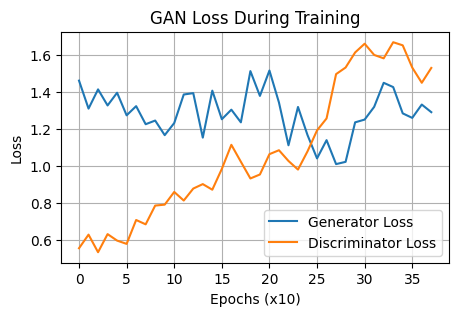

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - d_loss: 1.5602 - g_loss: 1.3573
Epoch 372/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - d_loss: 1.5840 - g_loss: 1.2705
Epoch 373/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - d_loss: 1.4043 - g_loss: 1.4401
Epoch 374/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 1.4729 - g_loss: 1.2360
Epoch 375/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.5442 - g_loss: 1.2573
Epoch 376/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - d_loss: 1.5771 - g_loss: 1.2602
Epoch 377/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.5682 - g_loss: 1.3304
Epoch 378/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - d_loss: 1.7699 - g_loss: 1.0489
Epoch 379/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.6660 - g_loss: 1.3812
Epoch 380/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 1.6332 - g_loss: 1.4844
Epoch 381/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - d_loss: 1.4816 - g_loss: 1.4260

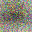

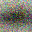

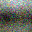

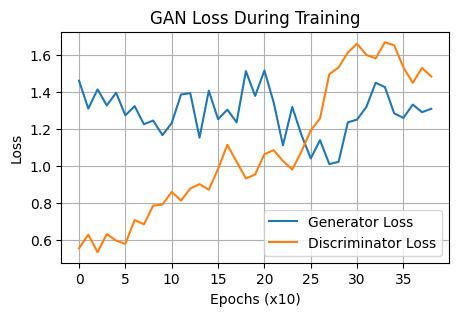

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - d_loss: 1.4817 - g_loss: 1.4153
Epoch 382/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.3505 - g_loss: 1.3975
Epoch 383/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.2845 - g_loss: 1.2637
Epoch 384/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - d_loss: 1.6283 - g_loss: 1.5660
Epoch 385/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - d_loss: 1.2902 - g_loss: 1.5123
Epoch 386/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.5168 - g_loss: 1.4215
Epoch 387/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.4793 - g_loss: 1.3001
Epoch 388/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.5810 - g_loss: 1.3907
Epoch 389/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 1.6194 - g_loss: 1.1738
Epoch 390/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - d_loss: 1.4333 - g_loss: 1.1537
Epoch 391/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - d_loss: 1.5147 - g_loss: 1.2668

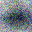

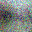

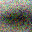

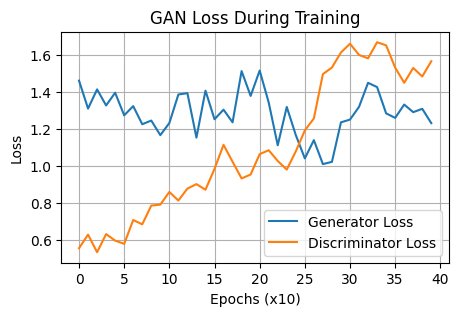

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - d_loss: 1.5193 - g_loss: 1.2636
Epoch 392/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 1.6776 - g_loss: 1.1960
Epoch 393/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 1.5666 - g_loss: 1.0081
Epoch 394/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - d_loss: 1.5535 - g_loss: 1.2004
Epoch 395/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.4732 - g_loss: 1.2505
Epoch 396/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.5253 - g_loss: 1.2552
Epoch 397/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - d_loss: 1.4587 - g_loss: 1.1462
Epoch 398/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - d_loss: 1.5245 - g_loss: 1.1017
Epoch 399/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.5178 - g_loss: 1.1629
Epoch 400/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.5484 - g_loss: 0.9942
Epoch 401/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - d_loss: 1.5818 - g_loss: 1.3113

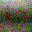

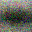

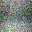

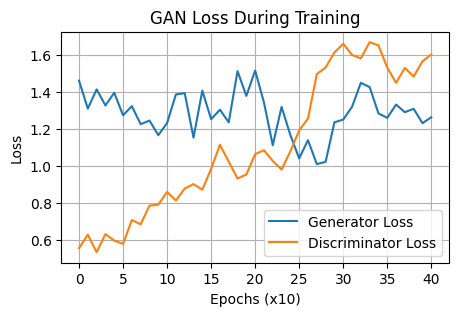

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - d_loss: 1.5835 - g_loss: 1.3070
Epoch 402/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - d_loss: 1.4549 - g_loss: 1.2512
Epoch 403/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - d_loss: 1.6054 - g_loss: 1.6550
Epoch 404/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.3687 - g_loss: 1.3854
Epoch 405/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - d_loss: 1.3746 - g_loss: 1.2463
Epoch 406/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - d_loss: 1.4247 - g_loss: 1.2178
Epoch 407/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.5589 - g_loss: 1.2997
Epoch 408/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.7221 - g_loss: 1.3282
Epoch 409/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - d_loss: 1.4773 - g_loss: 1.2821
Epoch 410/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - d_loss: 1.4094 - g_loss: 1.3227
Epoch 411/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - d_loss: 1.4445 - g_loss: 1.0497

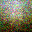

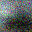

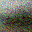

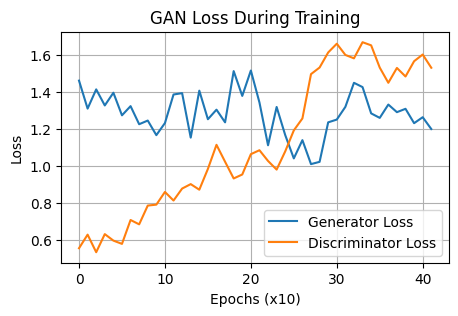

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - d_loss: 1.4523 - g_loss: 1.0634
Epoch 412/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 1.5427 - g_loss: 1.1889
Epoch 413/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - d_loss: 1.4387 - g_loss: 1.3021
Epoch 414/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - d_loss: 1.4298 - g_loss: 1.1572
Epoch 415/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - d_loss: 1.4519 - g_loss: 1.2858
Epoch 416/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.4158 - g_loss: 1.1737
Epoch 417/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.4753 - g_loss: 1.0588
Epoch 418/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 1.5289 - g_loss: 1.1961
Epoch 419/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - d_loss: 1.4563 - g_loss: 1.0672
Epoch 420/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - d_loss: 1.6163 - g_loss: 1.2305
Epoch 421/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - d_loss: 1.4281 - g_loss: 1.2730

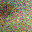

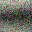

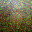

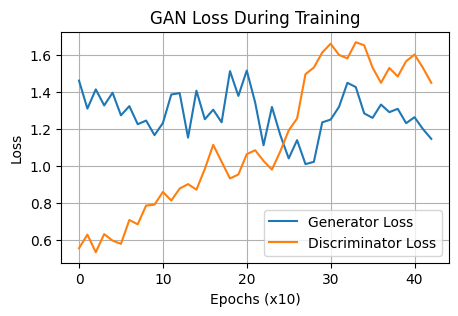

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - d_loss: 1.4299 - g_loss: 1.2616
Epoch 422/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.4980 - g_loss: 1.2157
Epoch 423/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - d_loss: 1.4892 - g_loss: 1.1931
Epoch 424/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - d_loss: 1.4481 - g_loss: 1.0430
Epoch 425/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.5303 - g_loss: 1.0912
Epoch 426/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 1.5828 - g_loss: 1.5343
Epoch 427/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 1.4690 - g_loss: 1.2171
Epoch 428/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 1.4489 - g_loss: 1.2262
Epoch 429/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.6454 - g_loss: 1.1824
Epoch 430/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 1.4311 - g_loss: 1.1032
Epoch 431/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - d_loss: 1.5521 - g_loss: 1.1035

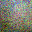

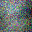

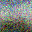

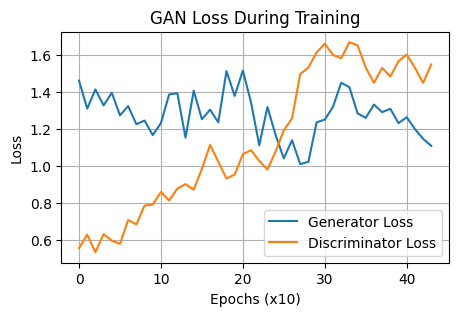

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - d_loss: 1.5516 - g_loss: 1.1040
Epoch 432/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.5328 - g_loss: 1.3034
Epoch 433/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.7352 - g_loss: 1.2566
Epoch 434/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.4747 - g_loss: 0.9815
Epoch 435/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - d_loss: 1.5166 - g_loss: 1.3120
Epoch 436/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.5093 - g_loss: 1.2600
Epoch 437/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.5281 - g_loss: 1.2846
Epoch 438/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.4873 - g_loss: 1.0904
Epoch 439/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - d_loss: 1.6616 - g_loss: 1.2599
Epoch 440/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - d_loss: 1.5349 - g_loss: 1.2434
Epoch 441/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - d_loss: 1.4764 - g_loss: 1.1797

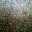

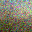

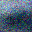

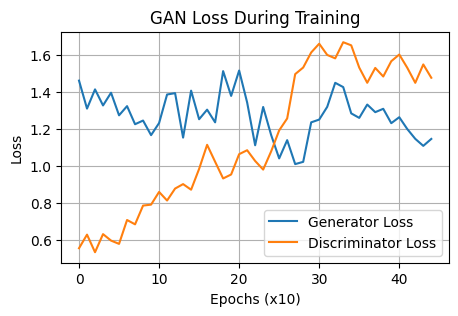

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - d_loss: 1.4764 - g_loss: 1.1767
Epoch 442/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - d_loss: 1.6128 - g_loss: 1.2884
Epoch 443/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 1.4946 - g_loss: 1.0980
Epoch 444/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 1.4758 - g_loss: 1.2087
Epoch 445/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - d_loss: 1.5320 - g_loss: 1.0971
Epoch 446/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 1.5029 - g_loss: 1.1025
Epoch 447/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - d_loss: 1.5852 - g_loss: 1.2416
Epoch 448/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 1.9302 - g_loss: 1.2702
Epoch 449/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - d_loss: 1.6703 - g_loss: 0.9680
Epoch 450/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.6486 - g_loss: 1.2557
Epoch 451/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - d_loss: 1.5460 - g_loss: 1.1461

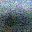

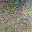

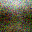

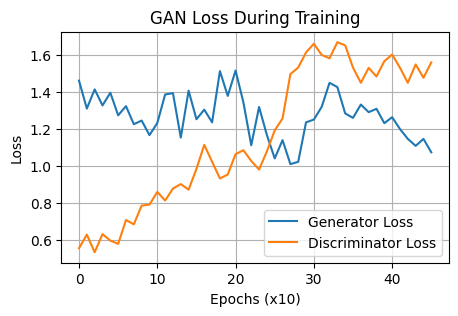

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - d_loss: 1.5472 - g_loss: 1.1396
Epoch 452/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - d_loss: 1.5984 - g_loss: 1.3501
Epoch 453/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - d_loss: 1.5359 - g_loss: 1.1187
Epoch 454/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.5068 - g_loss: 1.0951
Epoch 455/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.4848 - g_loss: 1.2421
Epoch 456/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - d_loss: 1.5354 - g_loss: 0.9142
Epoch 457/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - d_loss: 1.5044 - g_loss: 1.1081
Epoch 458/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - d_loss: 1.6729 - g_loss: 0.9524
Epoch 459/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - d_loss: 1.4872 - g_loss: 1.0345
Epoch 460/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - d_loss: 1.5666 - g_loss: 1.0847
Epoch 461/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - d_loss: 1.5938 - g_loss: 1.0221

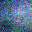

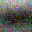

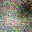

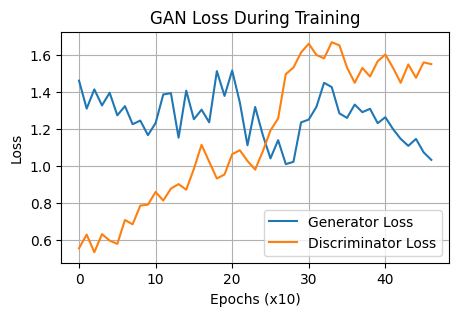

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - d_loss: 1.5898 - g_loss: 1.0232
Epoch 462/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.4877 - g_loss: 1.3218
Epoch 463/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.4885 - g_loss: 1.2098
Epoch 464/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - d_loss: 1.5616 - g_loss: 1.1805
Epoch 465/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - d_loss: 1.5093 - g_loss: 1.0275
Epoch 466/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - d_loss: 1.5917 - g_loss: 1.3298
Epoch 467/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.5346 - g_loss: 1.0786
Epoch 468/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - d_loss: 1.8315 - g_loss: 1.3944
Epoch 469/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 1.6619 - g_loss: 1.1044
Epoch 470/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.5658 - g_loss: 1.1808
Epoch 471/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - d_loss: 1.5175 - g_loss: 1.1306

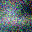

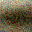

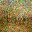

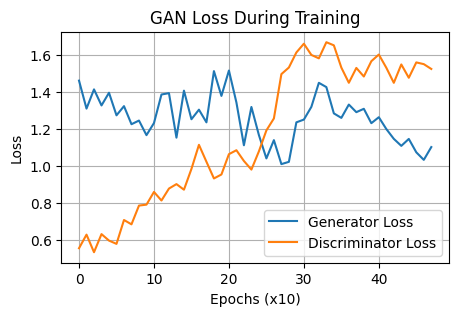

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - d_loss: 1.5181 - g_loss: 1.1281
Epoch 472/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - d_loss: 1.4899 - g_loss: 1.3531
Epoch 473/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.5264 - g_loss: 1.0487
Epoch 474/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.4631 - g_loss: 1.2153
Epoch 475/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - d_loss: 1.5032 - g_loss: 1.2030
Epoch 476/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - d_loss: 1.5527 - g_loss: 1.1678
Epoch 477/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - d_loss: 1.4491 - g_loss: 1.1649
Epoch 478/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.6548 - g_loss: 1.2740
Epoch 479/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - d_loss: 1.4601 - g_loss: 1.0631
Epoch 480/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 1.6489 - g_loss: 1.3022
Epoch 481/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - d_loss: 1.4812 - g_loss: 1.2925

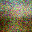

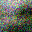

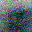

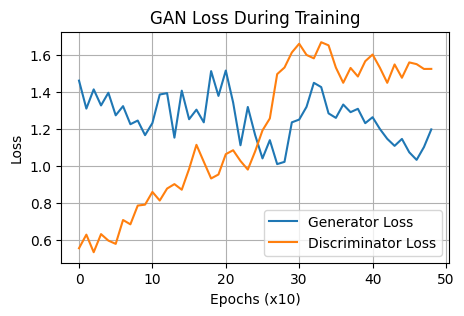

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - d_loss: 1.4850 - g_loss: 1.2839
Epoch 482/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - d_loss: 1.5276 - g_loss: 1.2173
Epoch 483/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - d_loss: 1.5724 - g_loss: 1.2667
Epoch 484/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - d_loss: 1.5621 - g_loss: 1.2044
Epoch 485/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.7904 - g_loss: 0.8719
Epoch 486/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - d_loss: 1.4648 - g_loss: 1.1468
Epoch 487/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.3868 - g_loss: 1.3642
Epoch 488/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - d_loss: 1.4723 - g_loss: 0.9850
Epoch 489/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.4045 - g_loss: 1.1060
Epoch 490/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.3409 - g_loss: 1.3664
Epoch 491/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - d_loss: 1.5797 - g_loss: 1.1913

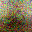

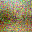

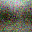

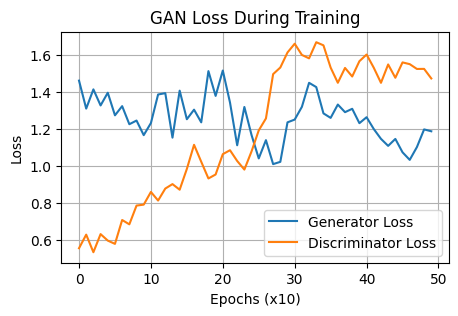

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - d_loss: 1.5699 - g_loss: 1.1910
Epoch 492/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - d_loss: 1.4870 - g_loss: 1.4958
Epoch 493/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - d_loss: 1.5112 - g_loss: 1.3535
Epoch 494/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - d_loss: 1.5070 - g_loss: 1.1921
Epoch 495/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - d_loss: 1.4866 - g_loss: 1.4086
Epoch 496/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - d_loss: 1.5239 - g_loss: 1.2066
Epoch 497/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - d_loss: 1.6844 - g_loss: 1.0879
Epoch 498/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - d_loss: 1.4805 - g_loss: 1.2501
Epoch 499/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.5793 - g_loss: 1.1397
Epoch 500/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - d_loss: 1.5941 - g_loss: 1.1946


In [105]:
epochs = 2000
history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, preview_freq=100,latent_dim=latent_dim)]
)

Generate a few images and see what is the model's output

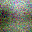

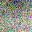

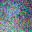

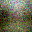

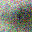

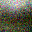

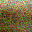

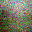

In [106]:
random_latent_vectors = keras.random.normal(
      shape=(8, latent_dim), seed=42
)
generated_images = gan.generator(random_latent_vectors, training=False)

for img in generated_images:
    display(keras.utils.array_to_img(img).resize((256,256)))

It looks like the network is catching on some interesting patterns such as using a pallete of similar colors, and having some shaded parts in the generated image. Overall not too bad!

# DCGAN

DCGANs (Deep Convolutional GANs) leverage convolutional layers in both the generator and discriminator, enabling them to learn hierarchical feature representations. This leads to more stable training and the generation of higher-quality images compared to vanilla GANs.

In [89]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),

        layers.Conv2D(32, kernel_size=3, strides=2, padding="same"),
        #layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        #layers.Dropout(0.5),

        layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
        #layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        #layers.Dropout(0.5),

        layers.Flatten(),
        #layers.Dense(8*8*128),
        #layers.LeakyReLU(negative_slope=0.2),
        #layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator_dcgan",
)
discriminator.summary()

In [91]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 512),
        #layers.BatchNormalization(),
        #layers.LeakyReLU(negative_slope=0.2),

        layers.Reshape((8, 8, 512)),

        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
        #layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        #layers.Dropout(0.2),

        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
        #layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        #layers.Dropout(0.2),


        layers.Conv2D(3, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator_dcgan",
)
generator.summary()

In [101]:
epochs = 2000
g_lr = 2e-4
d_lr = 2e-4

dc_gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, limit_d_loss=0.1)

#########################
#gan.freeze_discriminator = True # Testing
#########################

dc_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=d_lr, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=g_lr, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [ ]:
epochs = 100
history = dc_gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, preview_freq=100,latent_dim=latent_dim)]
)

In [ ]:
# Experimental, training the generator only for a couple epochs more
# gen_epochs = 1000
# gan.freeze_discriminator = True
# history_gen = gan.fit(
#     dataset, epochs=gen_epochs, callbacks=[GANMonitor(num_img=3, preview_freq=100,latent_dim=latent_dim)]
# )

Generate a few images and see what is the model's output

In [ ]:
random_latent_vectors = keras.random.normal(
      shape=(8, latent_dim), seed=42
)
generated_images = dc_gan.generator(random_latent_vectors, training=False)

for img in generated_images:
    display(keras.utils.array_to_img(img).resize((256,256)))

I have attempted many different weaks of this DCGAN network, and have failed to generate any decent looking images.
Most of the attempts have resulted in the generator loss going up and keep rising.

The best looking images generated during training had some cloud looking patterns to them, and this was achieved by limiting the discriminator in an attempt to stop it from overpowering the generator.

# Evaluating and saving the resulting images

In [ ]:
batches=60
output_dir='images'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for i in range(batches):

  random_latent_vectors = keras.random.normal(
      shape=(batch_size, latent_dim), seed=42
  )
  generated_images = gan.generator(random_latent_vectors)
  for j,img in enumerate(generated_images):
      keras.utils.array_to_img(img).resize((256,256)).save(os.path.join(output_dir,f"batch_{i}_img_{j}.jpg"))


In [ ]:
import zipfile

def zip_folder(folder_path, output_zip_path):
    """
    Zips a folder and its contents.

    Args:
        folder_path: The path to the folder to zip.
        output_zip_path: The path to the output zip file.  If the file
                         exists, it will be overwritten.
    Raises:
        FileNotFoundError: If the folder_path does not exist.
        ValueError: If `folder_path` is not a directory.
    """

    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder '{folder_path}' not found.")

    if not os.path.isdir(folder_path):
        raise ValueError(f"'{folder_path}' is not a directory.")

    try:
        with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, folder_path)  # Important for correct paths within the archive
                    zipf.write(file_path, arcname=arcname)
        print(f"Folder '{folder_path}' zipped successfully to '{output_zip_path}'")

    except Exception as e:
        print(f"An error occurred during zipping: {e}")



In [ ]:
zip_folder(output_dir,'images.zip')

In [ ]:
!rm -rf images

# Conclusions



In this notebook, we implemented a vanilla GAN and a DCGAN network to generate images resembling Monet's style.

We observed the training process through generated image previews and loss plots,

showcasing the evolution of the generator's ability to mimic the artistic style.

It was tremendously challenging to achieve any stable training proccess, and to generate images that are not complete noise.

Part of the challenge was the delicate balance between the generator and discriminator, and part of it was lack of hardware.

Further improvements could involve exploring advanced architectures (CycleGAN, BigGAN),
hyperparameter tuning, and experimenting with different loss functions to enhance image quality and fidelity to Monet's style.  The small dataset size might have limited the performance, and using a larger, more diverse dataset might yield superior results.


